# Task 2: Hyperelasticity



In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime
now = datetime.datetime.now

import importlib


2024-11-19 09:23:15.132204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 09:23:15.370510: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 09:23:15.445111: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 09:23:17.157313: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

### Data import

In [3]:
import random

# 假设有 100 个文件
file_list = [f"../../concentric/{i}.txt" for i in range(1, 100)]

# 确保随机选择可复现
random.seed(42)

# 按 70% 校准集，30% 测试集划分
calibration_files = random.sample(file_list, int(len(file_list) * 0.7))
test_files = [f for f in file_list if f not in calibration_files]

# 打印划分结果
print(f"Calibration files: {len(calibration_files)}")
print(f"Test files: {len(test_files)}")

print("Calibration set example:", calibration_files[:5])
print("Test set example:", test_files[:5])

Calibration files: 69
Test files: 30
Calibration set example: ['../../concentric/82.txt', '../../concentric/15.txt', '../../concentric/4.txt', '../../concentric/95.txt', '../../concentric/36.txt']
Test set example: ['../../concentric/2.txt', '../../concentric/9.txt', '../../concentric/10.txt', '../../concentric/11.txt', '../../concentric/16.txt']


In [64]:
import numpy as np
data_list = []
for file in calibration_files:
    data = np.loadtxt(file)  
    data_list.append(data)
F_train = np.concatenate(data_list, axis=0).reshape(-1, 3, 3)    
print(F_train.shape)

(3450, 3, 3)


In [65]:
import numpy as np
data_list = []
for file in test_files:
    data = np.loadtxt(file)  
    data_list.append(data.reshape(-1, 3, 3))
F_test = np.concatenate(data_list, axis=0)    
print(F_test.shape)

(1500, 3, 3)


In [66]:
import numpy as np

import tensorflow as tf

def compute_invariants(F):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    # F shape is (batch_size, 3, 3)
    batch_size = tf.shape(F)[0]
    
    # 计算右 Cauchy-Green 张量 C = F^T * F
    # Using einsum for batch matrix multiplication
    C = tf.einsum('bij,bjk->bik', tf.transpose(F, perm=[0, 2, 1]), F)
    
    # 计算不变量 I1, I2 和 J
    I1 = tf.linalg.trace(C)  # shape: (batch_size,)
    
    # For I2, compute trace(C@C) with batch operation
    C_square = tf.einsum('bij,bjk->bik', C, C)
    I2 = 0.5 * (I1**2 - tf.linalg.trace(C_square))  # shape: (batch_size,)
    
    # Compute determinant for each matrix in the batch
    J = tf.linalg.det(F)  # shape: (batch_size,)
    
    # 定义结构张量 Gti
    Gti = tf.constant([
        [4, 0, 0],
        [0, 0.5, 0],
        [0, 0, 0.5]
    ], dtype=tf.float32)
    
    # 扩展 Gti 到批量维度
    Gti = tf.tile(Gti[None, :, :], [batch_size, 1, 1])
    
    # 计算不变量 I4
    I4 = tf.linalg.trace(tf.einsum('bij,bjk->bik', C, Gti))  # shape: (batch_size,)
    
    # 计算 C 的余因子（Cofactor）
    # First compute inverse of C for each matrix in batch
    I3 = tf.linalg.det(C)

# 使用 I3 和 C 的逆计算 Cofactor 矩阵
    Cof_C = I3[:, None, None] * tf.linalg.inv(C)

    # 计算不变量 I5
    I5 = tf.linalg.trace(tf.einsum('bij,bjk->bik', Cof_C, Gti))  # shape: (batch_size,)
    
    return I1, J, I4, I5

In [67]:
#@tf.function
def neo_hookean_potential(I1, J, I4, I5):
    # 计算应变能密度 W
    W = 8 * I1 + 10 * (J ** 2) - 56 * tf.math.log(J) + 0.2 * (I4 ** 2 + I5 ** 2) - 44
    return W


In [68]:
# 计算应力张量 P
def compute_stress_tensor(F):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(F)
        
        # 计算不变量 I1, J, I4 和 I5
        I1, J, I4, I5 = compute_invariants(F)
        
        # 计算应变能函数 W
        W = neo_hookean_potential(I1, J, I4, I5)
    
    # 使用自动微分计算应力张量 P = dW/dF
    #print("W shape:", W.shape)
    P = tape.gradient(W, F)
    return P

In [69]:
P_train_tensor = compute_stress_tensor(F_train)
P_test_tensor = compute_stress_tensor(F_test)

In [70]:
print(P_train_tensor.shape)

(3450, 3, 3)


### Load naive model

In [54]:
import models_naive as lm
model_naive = lm.main()

model_naive.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6)]               0         
                                                                 
 private_c_to_p_1 (_C_to_P)  (None, 9)                 93        
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2500
108/108 [==============================] - 1s 2ms/step - loss: 432.2209 - val_loss: 421.7935
Epoch 2/2500
108/108 [==============================] - 0s 1ms/step - loss: 427.3940 - val_loss: 415.5015
Epoch 3/2500
108/108 [==============================] - 0s 1ms/step - loss: 419.7679 - val_loss: 405.2014
Epoch 4/2500
108/108 [==============================] - 0s 1ms/step - loss: 408.0264 - val_loss: 391.0965
Epoch 5/2500
108/108 [==============================] - 0s 1ms/step - loss: 393.3237 - val_loss: 376.5110
Epoch 6/2500
108/108 [==============================] - 0s 1ms/step - loss: 380.3825 - val_loss: 365.8190
Epoch 7/2500
108/108 [==============================] - 0s 1ms/step - loss: 371.4538 - val_loss: 357.1560
Epoch 8/2500
108/108 [==============================] - 0s 1ms/step - loss: 362.3661 - val_loss: 345.8734
Epoch 9/2500
108/108 [==============================] - 0s 1ms/step - loss: 349.7549 - val_loss: 330.6730
Epoch 10/2500
108/108 [=======================

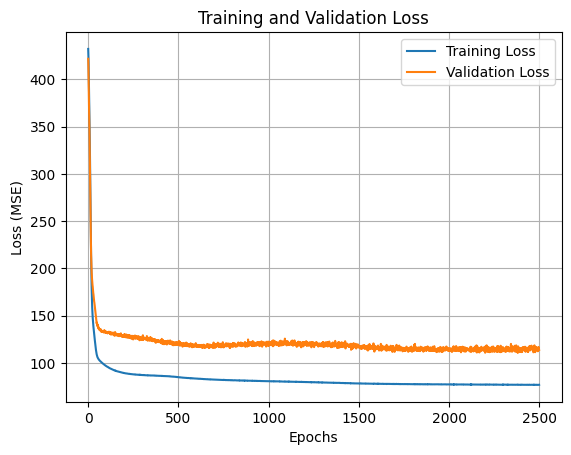

In [55]:
# 训练模型
def convert_F_to_C(F_data):
    # 将 F_data 重塑为 (N, 3, 3) 形状
    F_data = F_data.reshape(-1, 3, 3)
    # 对每个样本计算 C = F^T * F
    C_data = np.einsum('...ji,...jk->...ik', F_data, F_data)
    # 提取对称矩阵 C 的六个独立分量
    C_data_6 = np.stack([C_data[:, 0, 0],  # c11
                         C_data[:, 1, 1],  # c22
                         C_data[:, 2, 2],  # c33
                         C_data[:, 0, 1],  # c12
                         C_data[:, 0, 2],  # c13
                         C_data[:, 1, 2]], axis=-1)  # c23
    return C_data_6

# 转换训练和测试数据
C_train = convert_F_to_C(F_train)
C_test = convert_F_to_C(F_test)

P_train = P_train_tensor.numpy()
P_test = P_test_tensor.numpy()
P_train = P_train.reshape(-1, 9)
P_test = P_test.reshape(-1, 9)
history = model_naive.fit(C_train, P_train, epochs=2500, validation_data=(C_test, P_test))

# 训练过程的可视化
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


(3450, 3, 3)


108/108 [==============================] - 0s 586us/step


47/47 [==============================] - 0s 580us/step


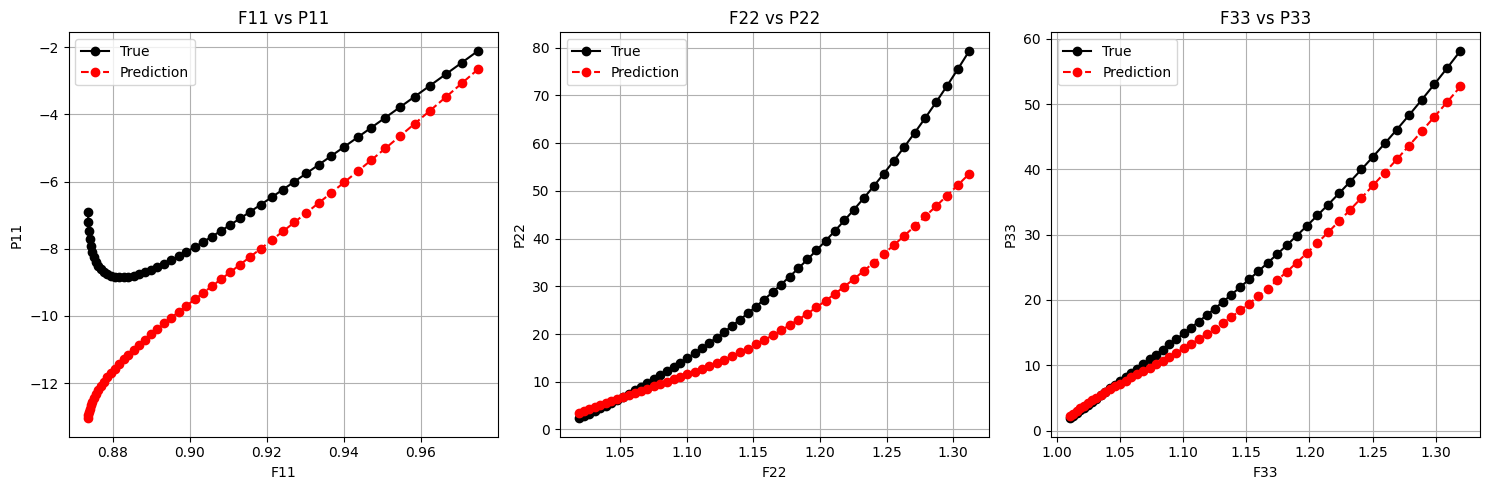

In [79]:
C_train = convert_F_to_C(F_train.reshape(-1, 9))
P_train = P_train.reshape(-1, 3, 3)
P_test = P_test.reshape(-1, 3, 3)
P_train_pred = model_naive.predict(C_train).reshape(-1, 3, 3)
P_test_pred = model_naive.predict(C_test).reshape(-1, 3, 3)
import matplotlib.pyplot as plt
import numpy as np

def plot_all_stress_vs_deformation(F_train, P_train, P_train_pred):
    # 提取 F 和 P 的不同分量
    F11 = F_train[:, 0, 0]  # 第一列
    F22 = F_train[:, 1, 1]  
    F33 = F_train[:, 2, 2] # 第三列

    P11 = P_train[:, 0, 0]  # 原始 P 的 11 元素
    P22 = P_train[:, 1, 1]  # 原始 P 的 22 元素
    P33 = P_train[:, 2, 2]  # 原始 P 的 33 元素

    P11_pred = P_train_pred[:, 0, 0]  # 预测 P 的 11 元素
    P22_pred = P_train_pred[:, 1, 1]  # 预测 P 的 22 元素
    P33_pred = P_train_pred[:, 2, 2]  # 预测 P 的 33 元素

    # 创建绘图
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    ax1.plot(F11, P11, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11, P11_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("F11 vs P11")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(F22, P22, label="True", marker="o", linestyle="-", color="black")
    ax2.plot(F22, P22_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax2.set_xlabel("F22")
    ax2.set_ylabel("P22")
    ax2.set_title("F22 vs P22")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(F33, P33, label="True", marker="o", linestyle="-", color="black")
    ax3.plot(F33, P33_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax3.set_xlabel("F33")
    ax3.set_ylabel("P33")
    ax3.set_title("F33 vs P33")
    ax3.legend()
    ax3.grid(True)

    # 调整布局
    plt.tight_layout()
    plt.show()

# 调用函数
plot_all_stress_vs_deformation(F_test[:50], P_test[:50], P_test_pred[:50])


### Load model

In [81]:

import models_icnn as lm2

import importlib
importlib.reload(lm2)
model_icnn = lm2.main()

model_icnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5)]               0         
                                                                 
 private_c_to_w (_C_to_W)    (None, 1)                 385       
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2500
108/108 [==============================] - 0s 820us/step - loss: 189.5284
Epoch 2/2500
108/108 [==============================] - 0s 775us/step - loss: 137.1781
Epoch 3/2500
108/108 [==============================] - 0s 803us/step - loss: 129.7637
Epoch 4/2500
108/108 [==============================] - 0s 788us/step - loss: 121.7050
Epoch 5/2500
108/108 [==============================] - 0s 794us/step - loss: 112.0518
Epoch 6/2500
108/108 [==============================] - 0s 797us/step - loss: 100.5285
Epoch 7/2500
108/108 [==============================] - 0s 795us/step - loss: 87.4011
Epoch 8/2500
108/108 [==============================] - 0s 812us/step - loss: 72.2987
Epoch 9/2500
108/108 [==============================] - 0s 785us/step - loss: 58.1398
Epoch 10/2500
108/108 [==============================] - 0s 814us/step - loss: 46.3690
Epoch 11/2500
108/108 [==============================] - 0s 792us/step - loss: 38.1800
Epoch 12/2500
108/108 [=======================

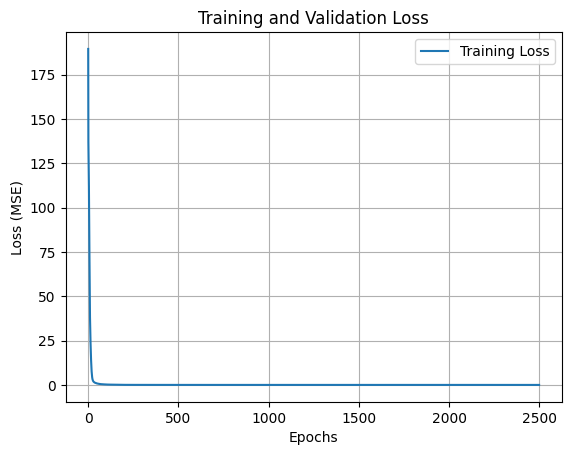

In [82]:
I1_data_train,J_data_train,I4_data_train,I5_data_train = compute_invariants(F_train) 
I_train = np.column_stack((I1_data_train, J_data_train, -J_data_train, I4_data_train, I5_data_train))
I_train_tensor = tf.convert_to_tensor(I_train, dtype=tf.float32)
W_train_tensor = neo_hookean_potential(I1_data_train, J_data_train, I4_data_train, I5_data_train)
history = model_icnn.fit(I_train_tensor, W_train_tensor, epochs=2500)


import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


In [83]:
def compute_stress_tensor(F,model):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(F)
        

        I1, J, I4, I5 = compute_invariants(F)
        I_train = tf.stack([I1, J, -J, I4, I5], axis=1)
        W_pred = model(I_train)

  
    P = tape.gradient(W_pred, F)
    
 
    #print("P:", P)
    
    return P

### Calibrate the model using both

In [84]:

optimizer = tf.optimizers.Adam(learning_rate=0.001)


def train_step(F, P_true, model):
    with tf.GradientTape(persistent=True) as tape:  
        tape.watch(F)
        
        
        I1, J, I4, I5 = compute_invariants(F)
        I_train = tf.stack([I1, J, -J, I4, I5], axis=1)
        W_pred = model(I_train)
        
        
        P_pred = tape.gradient(W_pred, F)
        
        
        loss_P = tf.reduce_mean(tf.square(P_pred - P_true))  
        loss = loss_P
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

In [85]:
F_train_tensor = tf.convert_to_tensor(F_train, dtype=tf.float32)

In [86]:
for epoch in range(2500):
   
    loss = train_step(F_train_tensor, P_train_tensor, model_icnn)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")

Epoch 1, Loss: 63.09434127807617
Epoch 2, Loss: 60.53459930419922
Epoch 3, Loss: 58.11574935913086
Epoch 4, Loss: 55.83258056640625
Epoch 5, Loss: 53.683799743652344
Epoch 6, Loss: 51.66371154785156
Epoch 7, Loss: 49.768985748291016
Epoch 8, Loss: 47.99712371826172
Epoch 9, Loss: 46.34573745727539
Epoch 10, Loss: 44.81161117553711
Epoch 11, Loss: 43.390106201171875
Epoch 12, Loss: 42.07624816894531
Epoch 13, Loss: 40.8644905090332
Epoch 14, Loss: 39.74888229370117
Epoch 15, Loss: 38.723236083984375
Epoch 16, Loss: 37.78130340576172
Epoch 17, Loss: 36.91689682006836
Epoch 18, Loss: 36.123817443847656
Epoch 19, Loss: 35.39628982543945
Epoch 20, Loss: 34.728912353515625
Epoch 21, Loss: 34.11662292480469
Epoch 22, Loss: 33.55476379394531
Epoch 23, Loss: 33.03910446166992
Epoch 24, Loss: 32.56576919555664
Epoch 25, Loss: 32.1312370300293
Epoch 26, Loss: 31.732275009155273
Epoch 27, Loss: 31.365915298461914
Epoch 28, Loss: 31.029375076293945
Epoch 29, Loss: 30.72007179260254
Epoch 30, Loss: 

In [87]:
P_train_pred = compute_stress_tensor(F_train,model_icnn)
P_test_pred = compute_stress_tensor(F_test,model_icnn)

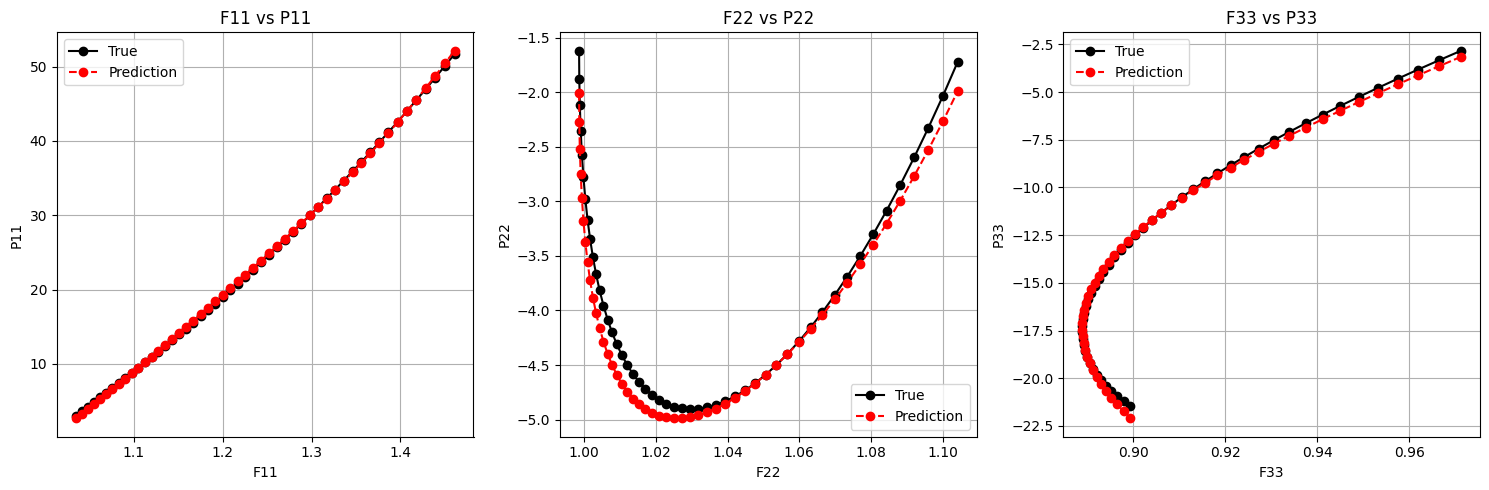

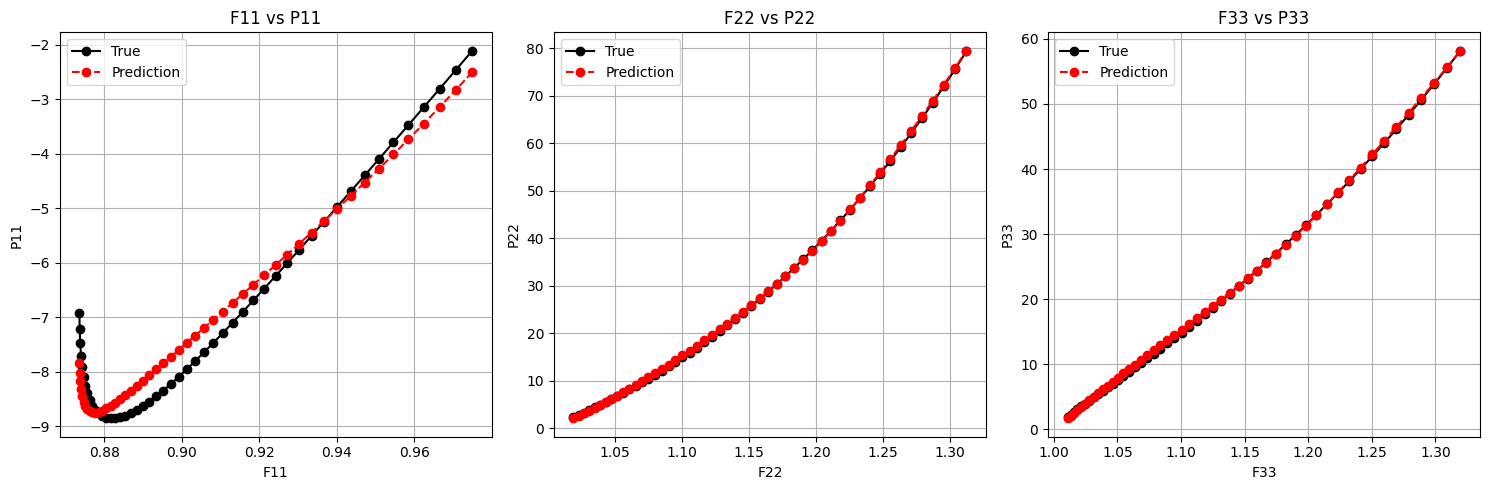

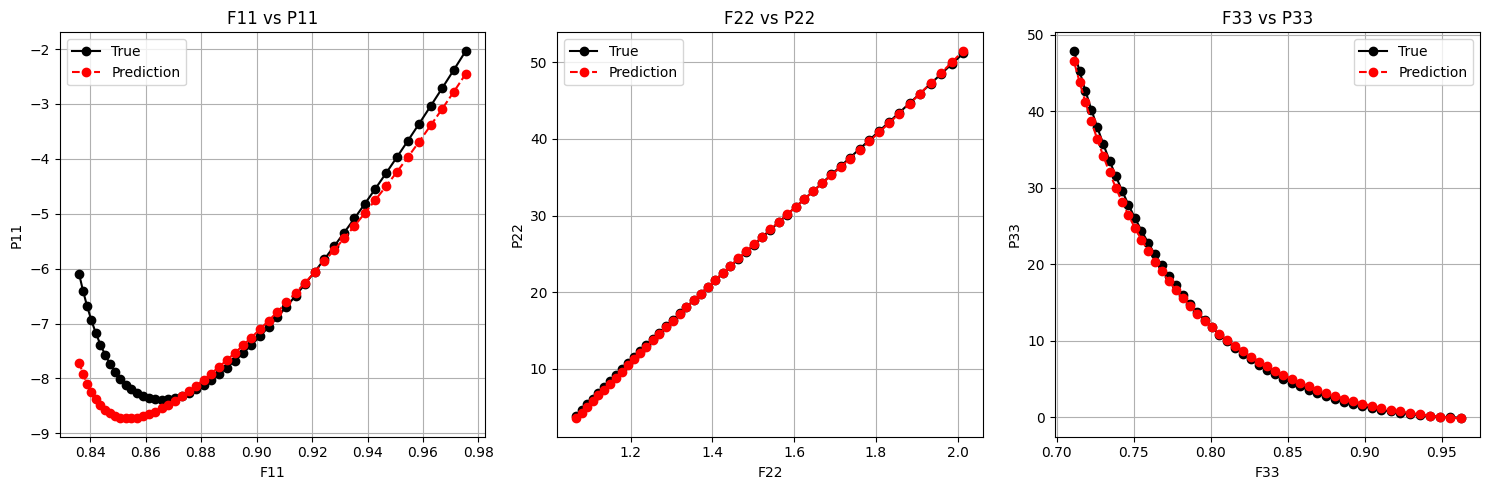

In [90]:
def plot_all_stress_vs_deformation(F_train, P_train, P_train_pred):

    F11 = F_train[:, 0, 0]  
    F22 = F_train[:, 1, 1]  
    F33 = F_train[:, 2, 2] 

    P11 = P_train[:, 0, 0]  
    P22 = P_train[:, 1, 1]  
    P33 = P_train[:, 2, 2]  

    P11_pred = P_train_pred[:, 0, 0] 
    P22_pred = P_train_pred[:, 1, 1] 
    P33_pred = P_train_pred[:, 2, 2] 


    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    ax1.plot(F11, P11, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11, P11_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("F11 vs P11")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(F22, P22, label="True", marker="o", linestyle="-", color="black")
    ax2.plot(F22, P22_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax2.set_xlabel("F22")
    ax2.set_ylabel("P22")
    ax2.set_title("F22 vs P22")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(F33, P33, label="True", marker="o", linestyle="-", color="black")
    ax3.plot(F33, P33_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax3.set_xlabel("F33")
    ax3.set_ylabel("P33")
    ax3.set_title("F33 vs P33")
    ax3.legend()
    ax3.grid(True)

  
    plt.tight_layout()
    plt.show()


plot_all_stress_vs_deformation(F_train[:50], P_train[:50], P_train_pred[:50])
plot_all_stress_vs_deformation(F_test[:50], P_test[:50], P_test_pred[:50])
plot_all_stress_vs_deformation(F_test[50:100], P_test[50:100], P_test_pred[50:100])
